In [4]:
import numpy as np
from scipy.sparse.linalg import expm
from scipy.constants import hbar, pi
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from sim_functions import time_evolve, gen_ham_free, gen_ham_plus, gen_ham_minus

# Note: double check these at some point
m = 85.47*1.6605e-27 # Rb-85 mass
kb = 1.38064852e-23 # Boltzmann's constant
omega_2 = 2*pi*(384.230406373e12 - 1.264888e9) # Beam 2 freq.
omega_1 = 2*pi*(384.230406373e12 + 1.770843e9) # Beam 1 freq.
omega_eg = omega_1 - omega_2 # Hyperfine splitting.
k_eff = (omega_1+omega_2)/(2.998e8) # Effective wavevector.
dR = (hbar*(k_eff)**2)/(2*m) # two-photon recoil shift
print(dR/2*pi)

151374.93221726542


In [26]:
# Pulse Sequence
# n x 6 2d array
# delta_L, phi, rabi_freq, dir (0 for up, 1 for down), pulse_length, free_length

# Defining function to generate the (+-+-) resonant pulse sequence

def gen_resonant_pm_seq(no_pulses, rabi_freq):

    pulse_seq = np.zeros((no_pulses, 6))
    
    for n in range(no_pulses):
        pulse_seq[n,:] = [((-1)**n)*(2*n + 1)*dR, 0, rabi_freq, n % 2, pi/rabi_freq, 0]

    return pulse_seq

pulse_seq1 = gen_resonant_pm_seq(4, 2*pi*100000)


In [33]:
# General func to take in pulse sequence and generate the final momentum distribution
# RNG seed info gets saved so you can reproduce same distribution

def simulate_pulses(pulse_seq, Temp, no_atoms, basis, initial_state):

    rng = np.random.default_rng()
    rng_state = rng.bit_generator.state
    
    sigma = np.sqrt(kb*Temp/m)
    atom_veloc = rng.normal(loc = 0, scale = sigma, size = no_atoms)

    

    data = np.zeros((np.size(basis), np.size(atom_veloc)))

    for v in range(len(atom_veloc)):
        state_vec = initial_state

        for pulse in pulse_seq:

            if not bool(pulse[3]):
                Hint = gen_ham_plus(basis = basis,
                  phi_L = pulse[1],
                  omega_R_plus = pulse[2],
                )
            else:
                Hint = gen_ham_minus(basis = basis,
                  phi_L = pulse[1],
                  omega_R_minus = pulse[2],
                )
            H0 = gen_ham_free(basis = basis,
                  delta_L = pulse[0], 
                  delta_D = k_eff*atom_veloc[v],
                  delta_R = dR,
            )

            state_vec = time_evolve(pulse[4], Hint + H0) @ state_vec

        
        square = np.abs(state_vec)**2
        data[:,v] = square


    init_mom_dist = atom_veloc*m
    init_mom_dist_tiled = np.tile(init_mom_dist, (len(basis),1))

    basis_tiled = np.transpose(np.tile(basis, (len(atom_veloc),1)))

    final_mom_dist_tiled = init_mom_dist_tiled + (hbar*k_eff*basis_tiled)

    final_mom_dist = np.ravel(final_mom_dist_tiled)

    state_fractions = np.ravel(data)
    
    return final_mom_dist, state_fractions, init_mom_dist, rng_state

# simulate_pulses(pulse_seq1, 10e-6, 1, np.array([0,1,2,3,4]), np.array([1,0,0,0,0]))





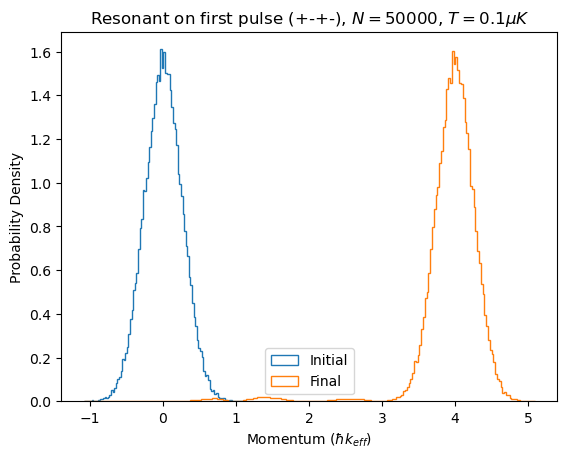

In [36]:
N = 50000
Temp = 0.1e-6

final, fracs, init, _ = simulate_pulses(pulse_seq1, Temp, N, np.array([0,1,2,3,4]), np.array([1,0,0,0,0]))

final = final/(hbar*k_eff)
init = init/(hbar*k_eff)

plt.hist(x = init, bins = 100, histtype='step',density=True,label='Initial')
plt.hist(x = final, bins = 250, weights=fracs, histtype='step',density=True, label='Final')
plt.title(rf"Resonant on first pulse (+-+-), $N={N}$, $T={Temp*1e6:.3g}\mu K$")
plt.ylabel('Probability Density')
plt.xlabel(r"Momentum ($\hbar k_{eff}$)")
plt.legend()
plt.show()